In [1]:
"""
Spatial Analysis of Weather Data
================================

This notebook performs spatial analysis of weather variables across the UK region,
including the visualization of statistical properties, spatial variability, and
coefficient of variation analysis.

Variables analyzed:
- d2m: 2-meter dewpoint temperature (K)
- u: U-component of wind (m/s)
- v: V-component of wind (m/s)
- msl: Mean sea level pressure (Pa)
- r: Relative humidity (%)

Key analyses:
1. Statistical properties (mean, std, min, max) of weather variables
2. Coefficient of Variation (CV) analysis
3. Spatial autocorrelation using Moran's I
4. Cartographic visualization with Cartopy
"""

# Standard library imports
import os
import sys
from datetime import datetime

# Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Geospatial libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Spatial statistics (optional, used in Moran's I analysis)
try:
    from pysal.explore.esda import Moran
    from libpysal.weights import lat2W
    PYSAL_AVAILABLE = True
except ImportError:
    PYSAL_AVAILABLE = False
    print("Warning: PySAL not available - Moran's I analysis will be skipped")


/home/yuhan/Desktop/Master/conda_master_v0/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/home/yuhan/Desktop/Master/conda_master_v0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yuhan/Desktop/Master/conda_master_v0/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [3]:
def setup_environment():
    """
    Set up the project environment by configuring paths and importing project modules.
    
    Returns:
        str: Current working directory
    """
    try:
        # Navigate to project root directory
        os.chdir("../")
    except Exception as e:
        print(f"Error changing directory: {e}")
    
    # Get and print current working directory
    current_directory = os.getcwd()
    print(f"Current Directory: {current_directory}")
    
    # Add notebooks directory to path
    notebooks_path = os.path.abspath(os.path.join(current_directory, "notebooks"))
    if notebooks_path not in sys.path:
        sys.path.append(notebooks_path)
    
    return current_directory

def set_plot_style(size=16):
    """
    Configure consistent matplotlib plot style settings
    
    Args:
        size (int): Base font size for plots
    """
    plt.rcParams.update({
        'font.size': size,         
        'axes.titlesize': size,    
        'axes.labelsize': size,    
        'xtick.labelsize': size-2, 
        'ytick.labelsize': size-2, 
        'legend.fontsize': size-2,
    })

def load_weather_data(variables, frequency, time_unit, method, preprocessing, year_range):
    """
    Load weather data based on specified parameters
    
    Args:
        variables (str): String identifying the variables (e.g., 'd2muvmslr')
        frequency (int): Temporal frequency
        time_unit (str): Time unit ('h' for hours, 'd' for days)
        method (str): Resampling method
        preprocessing (str): Preprocessing method
        year_range (tuple): Tuple of (start_year, end_year)
        
    Returns:
        Tuple: (all_variables_data, data_array, timestamps)
            - all_variables_data: Raw data from netCDF file
            - data_array: Numpy array of data without timestamps
            - timestamps: List of timestamps
    """
    # Construct file path
    file_path = f"data/processed/{variables}_{frequency}{time_unit}_{method}_{preprocessing}_{year_range[0]}{year_range[1]}.h5"
    print(f"Loading data from: {file_path}")
    
    # Import project utilities
    try:
        from utils.utils_data import read_netcdf
        
        # Load the data
        all_variables_data = read_netcdf(file_path)
        print(f"Data loaded successfully. {len(all_variables_data)} time points.")
        
        # Extract timestamps and data arrays
        timestamps = [item[0] for item in all_variables_data]
        data_array = np.array([item[1] for item in all_variables_data], dtype=np.float32)
        
        print(f"Data shape: {data_array.shape}")
        return all_variables_data, data_array, timestamps
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Setup the environment
current_dir = setup_environment()

# Import project utilities
try:
    from utils.utils import load_json_config
except ImportError as e:
    print(f"Error importing modules: {e}")

# Apply plot style
set_plot_style()

# Define data parameters
variables = "d2muvmslr"
variable_list = ["d2m", "u", "v", "msl", "r"]
variable_units = ['K', 'm/s', 'm/s', 'Pa', '%']
selected_frequency = 1
time_unit = "h"
resample_method = "none"
preprocessing_method = "raw"
year_range = (2004, 2020)

# Load weather data
all_variables_data, atmosphere_data, timestamps = load_weather_data(
    variables=variables,
    frequency=selected_frequency,
    time_unit=time_unit,
    method=resample_method,
    preprocessing=preprocessing_method,
    year_range=year_range
)

# Print data dimensions
print(f"Number of timestamps: {len(timestamps)}")
print(f"Data array shape: {atmosphere_data.shape}")

Current Directory: /home/yuhan/Desktop/Master
Loading data from: data/processed/d2muvmslr_1h_none_raw_20042020.h5
Data loaded successfully. 146736 time points.
Data shape: (146736, 5, 32, 32)
Number of timestamps: 146736
Data array shape: (146736, 5, 32, 32)


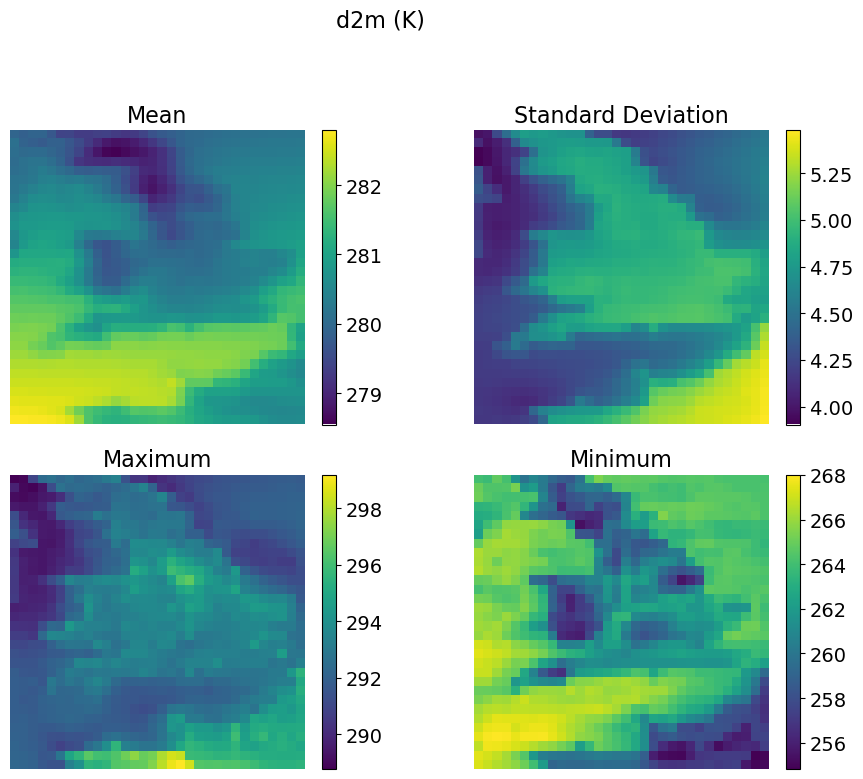

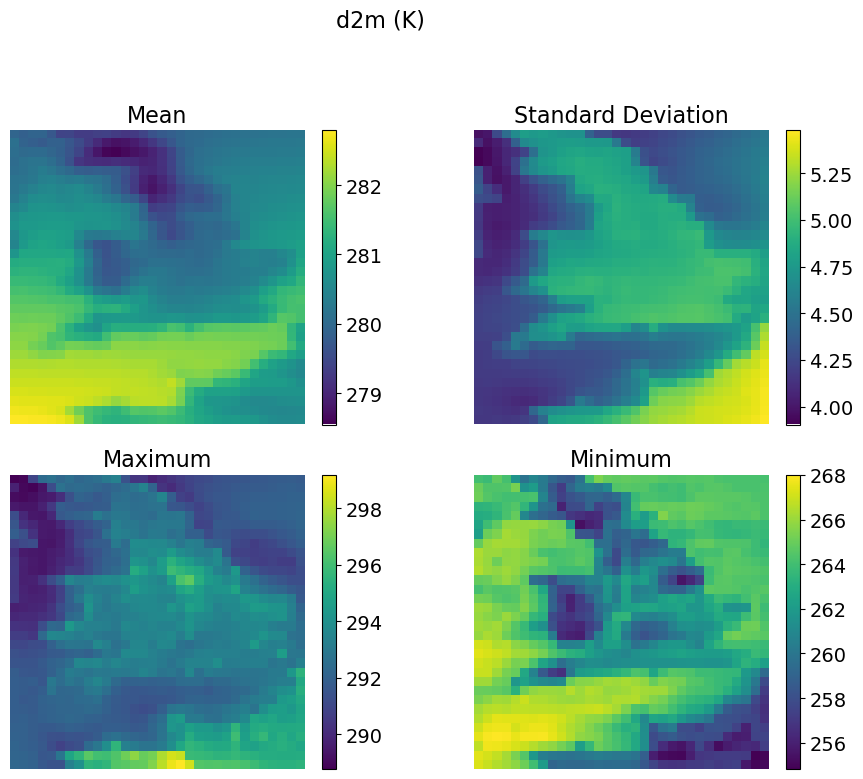

In [4]:
def plot_statistics_grid(variable_data, var_name, var_unit, with_cartopy=False, time_range=None):
    """
    Plot a 2x2 grid of statistical maps (mean, std, max, min) for a given variable.
    
    Args:
        variable_data (numpy.ndarray): Data array of shape (time, height, width)
        var_name (str): Variable name for the title
        var_unit (str): Variable unit for the title
        with_cartopy (bool): Whether to include cartopy map features
        time_range (int, optional): Number of time points to use, if None uses all data
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Select data range if specified
    if time_range is not None:
        data = variable_data[:time_range, :, :]
    else:
        data = variable_data
    
    # Calculate statistics
    mean_map = np.mean(data, axis=0)
    std_map = np.std(data, axis=0)
    max_map = np.max(data, axis=0)
    min_map = np.min(data, axis=0)
    
    # Create figure and set subplot parameters
    kwargs = {}
    if with_cartopy:
        kwargs['subplot_kw'] = {'projection': ccrs.PlateCarree()}
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8), **kwargs)
    fig.suptitle(f"{var_name} ({var_unit})", fontsize=16)
    
    # Define the layout for our plots
    stats = [
        {"data": mean_map, "title": "Mean", "pos": (0, 0)},
        {"data": std_map, "title": "Standard Deviation", "pos": (0, 1)},
        {"data": max_map, "title": "Maximum", "pos": (1, 0)},
        {"data": min_map, "title": "Minimum", "pos": (1, 1)}
    ]
    
    # Plot each statistic
    for stat in stats:
        ax = axes[stat["pos"]]
        
        if with_cartopy:
            # Set map extent and add features
            ax.set_extent([-6, 2, 48, 56])
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
            ax.add_feature(cfeature.LAKES, alpha=0.5)
            
            # Plot data on map
            im = ax.imshow(
                stat["data"], 
                cmap="viridis", 
                extent=[-6, 2, 48, 56], 
                transform=ccrs.PlateCarree()
            )
        else:
            # Simple plot without map features
            im = ax.imshow(stat["data"], cmap="viridis")
            ax.axis('off')
        
        # Add title and colorbar
        ax.set_title(stat["title"])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig

def compute_coefficient_of_variation(data, log_transform=True, clip_percentile=None):
    """
    Compute coefficient of variation (CV) for a data array.
    
    Args:
        data (numpy.ndarray): Data array of shape (time, height, width)
        log_transform (bool): Whether to apply log10 transformation to the CV
        clip_percentile (float, optional): Percentile to clip extreme values
    
    Returns:
        numpy.ndarray: CV map (or log10(CV) if log_transform=True)
    """
    # Calculate mean and standard deviation
    mean_map = np.mean(data, axis=0)
    std_map = np.std(data, axis=0)
    
    # Calculate CV (std/mean), handling division by zero
    cv_map = np.divide(std_map, mean_map, out=np.zeros_like(std_map), where=mean_map != 0)
    
    # Optional: clip extreme values
    if clip_percentile is not None:
        max_val = np.nanpercentile(cv_map, clip_percentile)
        cv_map = np.clip(cv_map, 0, max_val)
    
    # Optional: log transform
    if log_transform:
        # Ensure positive values for log transform
        cv_map = np.log10(cv_map, where=cv_map > 0)
    
    return cv_map

# Create a consistent data reference
data = atmosphere_data  # Use the original variable name

# Test the plotting function with the first variable
var_idx = 0
var_data = data[:, var_idx, :, :]
plot_statistics_grid(
    var_data, 
    var_name=variable_list[var_idx], 
    var_unit=variable_units[var_idx]
)

/tmp/ipykernel_254438/363297914.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


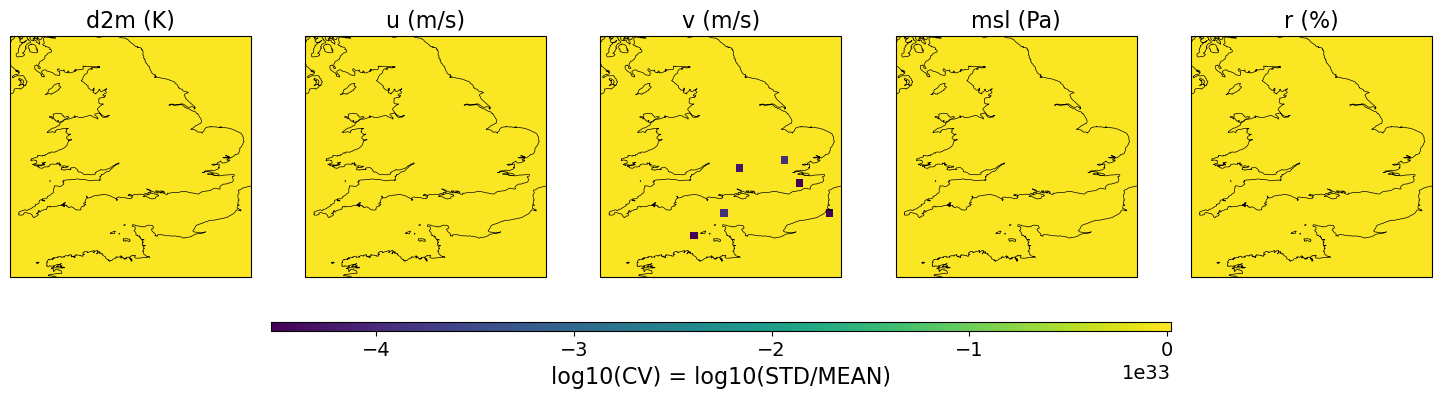

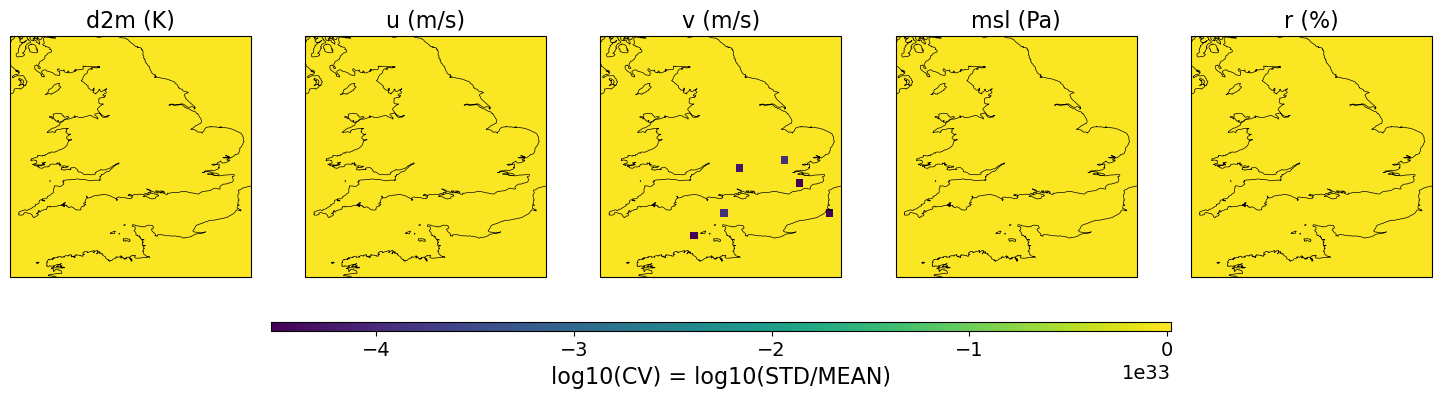

In [5]:
def plot_cv_comparison(data, variable_list, variable_units, time_range=366, with_cartopy=True):
    """
    Plot a comparison of coefficient of variation (CV) across multiple variables.
    
    Args:
        data (numpy.ndarray): Full data array of shape (time, variables, height, width)
        variable_list (list): List of variable names
        variable_units (list): List of variable units
        time_range (int): Number of timestamps to use for calculation
        with_cartopy (bool): Whether to use Cartopy for map visualization
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Calculate CV (or log10(CV)) for all variables
    cv_maps_log = []
    vmin, vmax = float('inf'), float('-inf')
    
    for var_idx in range(len(variable_list)):
        # Extract variable data
        variable_data = data[:time_range, var_idx, :, :]
        
        # Compute CV with log transform
        cv_map_log = compute_coefficient_of_variation(variable_data, log_transform=True)
        cv_maps_log.append(cv_map_log)
        
        # Update colorbar range
        vmin = min(vmin, np.nanmin(cv_map_log))
        vmax = max(vmax, np.nanmax(cv_map_log))
    
    # Create figure with appropriate projection if using Cartopy
    kwargs = {}
    if with_cartopy:
        kwargs['subplot_kw'] = {'projection': ccrs.PlateCarree()}
    
    fig, axes = plt.subplots(1, len(variable_list), figsize=(15, 3), sharex=True, sharey=True, **kwargs)
    
    # Plot each variable's CV map
    for idx, ax in enumerate(axes):
        if with_cartopy:
            # Set map extent and add features
            ax.set_extent([-6, 2, 48, 56])
            ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
            ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
            ax.add_feature(cfeature.LAKES, alpha=0.5)
            
            # Add data layer
            im = ax.imshow(
                cv_maps_log[idx], 
                cmap="viridis", 
                vmin=vmin, vmax=vmax,
                origin="upper",
                extent=[-6, 2, 48, 56], 
                transform=ccrs.PlateCarree()
            )
        else:
            # Simple plot without map features
            im = ax.imshow(cv_maps_log[idx], cmap="viridis", vmin=vmin, vmax=vmax)
            ax.axis('off')
        
        # Add title
        ax.set_title(f"{variable_list[idx]} ({variable_units[idx]})")
    
    # Add shared colorbar
    if with_cartopy:
        cax = fig.add_axes([0.2, -0.1, 0.6, 0.03])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cax, orientation='horizontal', pad=0.1)
    else:
        cbar = fig.colorbar(im, ax=axes, orientation="horizontal", fraction=0.1, pad=0.1, shrink=1)
    
    cbar.set_label("log10(CV) = log10(STD/MEAN)")
    plt.tight_layout()
    
    return fig

def calculate_spatial_statistics(data, variable_list, time_range=366):
    """
    Calculate spatial statistics for multiple variables.
    
    Args:
        data (numpy.ndarray): Full data array of shape (time, variables, height, width)
        variable_list (list): List of variable names
        time_range (int): Number of timestamps to use for calculation
    
    Returns:
        dict: Dictionary of spatial statistics for each variable
    """
    # Initialize dictionary to store statistics
    spatial_stats = {var_name: {} for var_name in variable_list}
    
    # Calculate statistics for each variable
    for var_idx, var_name in enumerate(variable_list):
        print(f"Processing variable: {var_name}")
        
        # Extract variable data
        variable_data = data[:time_range, var_idx, :, :]
        
        # Calculate statistics
        spatial_stats[var_name]['mean'] = np.mean(variable_data, axis=0)
        spatial_stats[var_name]['std'] = np.std(variable_data, axis=0)
        spatial_stats[var_name]['max'] = np.max(variable_data, axis=0)
        spatial_stats[var_name]['min'] = np.min(variable_data, axis=0)
        
        # Calculate CV
        cv = compute_coefficient_of_variation(variable_data, log_transform=False)
        spatial_stats[var_name]['cv'] = cv
    
    return spatial_stats

def calculate_morans_i(spatial_stats, variable_list):
    """
    Calculate Moran's I spatial autocorrelation for each variable and statistic.
    
    Args:
        spatial_stats (dict): Dictionary of spatial statistics from calculate_spatial_statistics
        variable_list (list): List of variable names
    
    Returns:
        dict: Dictionary of Moran's I values for each statistic and variable
    """
    if not PYSAL_AVAILABLE:
        print("PySAL not available - Moran's I analysis skipped")
        return None
    
    # Initialize results dictionary
    moran_results = {"mean": [], "std": [], "max": [], "min": [], "cv": []}
    
    # Create weights matrix (assumes 32x32 grid)
    w = lat2W(32, 32)
    w.transform = 'r'  # Row-standardize weights
    
    # Calculate Moran's I for each statistic and variable
    for stat in moran_results.keys():
        for var_name in variable_list:
            data = spatial_stats[var_name][stat].flatten()
            moran = Moran(data, w)
            moran_results[stat].append(moran.I)
    
    return moran_results

# Visualize coefficient of variation for all variables
plot_cv_comparison(data, variable_list, variable_units)

Processing variable: d2m
Processing variable: u
Processing variable: v
Processing variable: msl
Processing variable: r


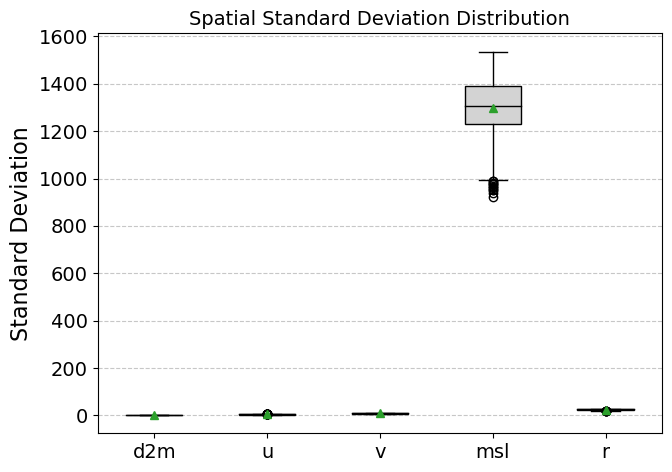

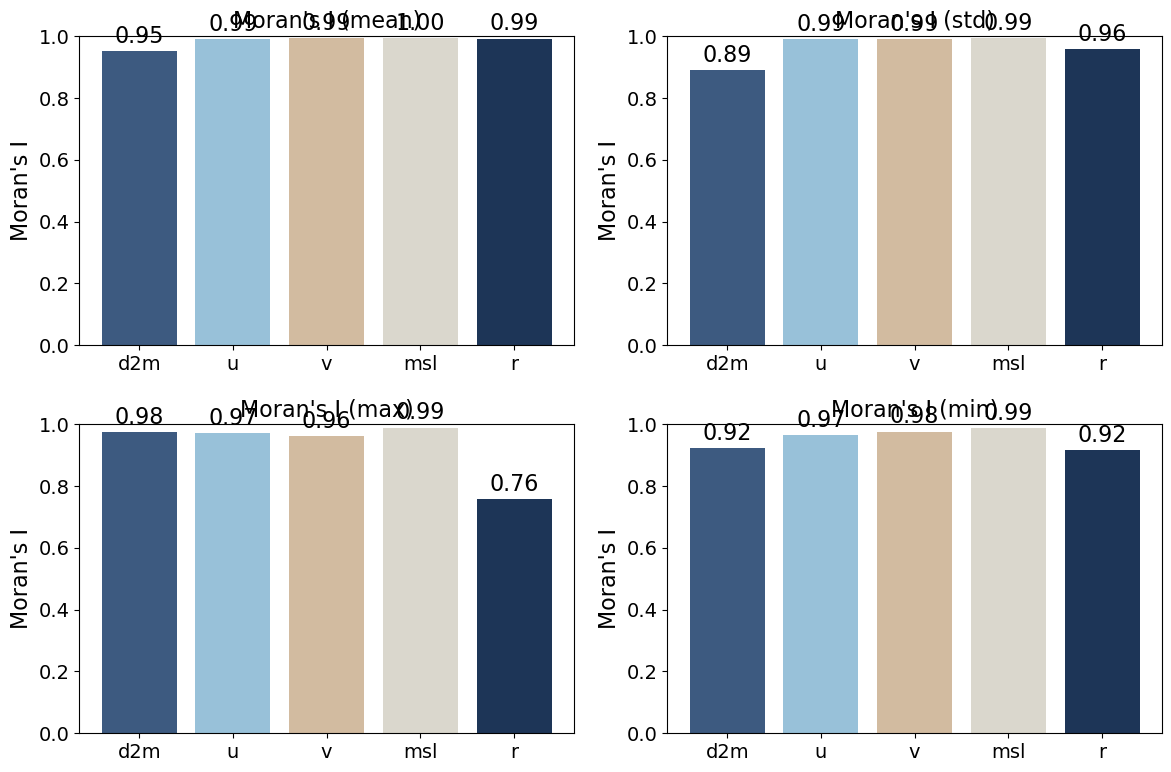

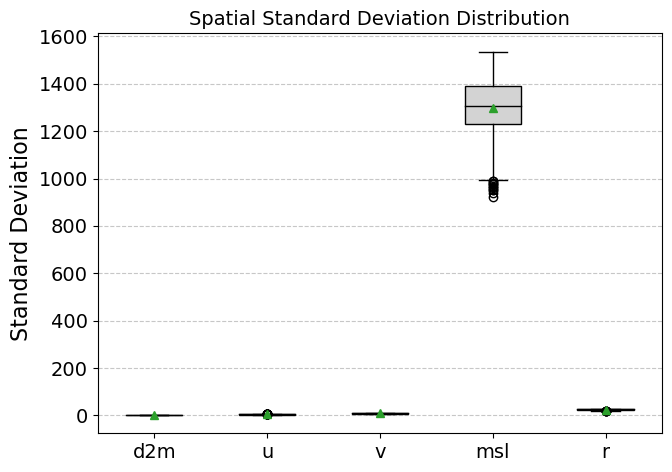

In [6]:
def plot_morans_i(moran_results, variable_list):
    """
    Plot Moran's I results for each variable and statistic.
    
    Args:
        moran_results (dict): Dictionary of Moran's I values from calculate_morans_i
        variable_list (list): List of variable names
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    if moran_results is None:
        print("No Moran's I results to plot - PySAL not available")
        return None
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    colors = ["#3d5a80", "#98c1d9", "#d2bba0", "#dad7cd", "#1d3557"]
    
    # Plot each statistic
    for idx, stat in enumerate(["mean", "std", "max", "min"]):
        ax = axes[idx]
        ax.bar(variable_list, moran_results[stat], color=colors)
        ax.set_title(f"Moran's I ({stat})")
        ax.set_ylabel("Moran's I")
        ax.set_ylim(0, 1)
        
        # Add value annotations
        for i, value in enumerate(moran_results[stat]):
            ax.text(i, value + 0.01, f"{value:.2f}", ha="center", va="bottom")
    
    plt.tight_layout()
    return fig

def plot_variable_boxplot(data, variable_list, variable_units, stat_type="std", time_range=366):
    """
    Create a boxplot showing the distribution of a statistic across variables.
    
    Args:
        data (numpy.ndarray): Full data array of shape (time, variables, height, width)
        variable_list (list): List of variable names
        variable_units (list): List of variable units
        stat_type (str): Statistic to plot ('std', 'mean', 'cv', etc.)
        time_range (int): Number of timestamps to use
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Compute statistics for each variable
    stat_data_list = []
    
    for var_idx, var_name in enumerate(variable_list):
        # Extract variable data
        variable_data = data[:time_range, var_idx, :, :]
        
        if stat_type == "std":
            # Calculate standard deviation
            stat_map = np.std(variable_data, axis=0)
        elif stat_type == "mean":
            # Calculate mean
            stat_map = np.mean(variable_data, axis=0)
        elif stat_type == "cv":
            # Calculate coefficient of variation
            mean_map = np.mean(variable_data, axis=0)
            std_map = np.std(variable_data, axis=0)
            stat_map = np.divide(std_map, mean_map, out=np.zeros_like(std_map), where=mean_map != 0)
        else:
            raise ValueError(f"Unknown stat_type: {stat_type}")
        
        # Flatten to 1D array and add to list
        stat_values = stat_map.flatten()
        stat_data_list.append(stat_values)
    
    # Create boxplot
    fig, ax = plt.subplots(figsize=(7, 5))
    bp = ax.boxplot(
        stat_data_list, 
        labels=variable_list, 
        showmeans=True, 
        patch_artist=True, 
        boxprops=dict(facecolor='lightgray'), 
        medianprops=dict(color='black')
    )
    
    # Set title and labels
    title_map = {
        "std": "Standard Deviation",
        "mean": "Mean",
        "cv": "Coefficient of Variation (STD/MEAN)"
    }
    ax.set_title(f"Spatial {title_map.get(stat_type, stat_type)} Distribution", fontsize=14)
    ax.set_ylabel(title_map.get(stat_type, stat_type))
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    return fig

# Calculate spatial statistics for all variables
spatial_stats = calculate_spatial_statistics(data, variable_list)

# Calculate Moran's I if PySAL is available
if PYSAL_AVAILABLE:
    moran_results = calculate_morans_i(spatial_stats, variable_list)
    plot_morans_i(moran_results, variable_list)
else:
    print("Skipping Moran's I analysis - PySAL not available")

# Plot boxplot of standard deviations across variables
plot_variable_boxplot(data, variable_list, variable_units, stat_type="std")

/tmp/ipykernel_254438/363297914.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


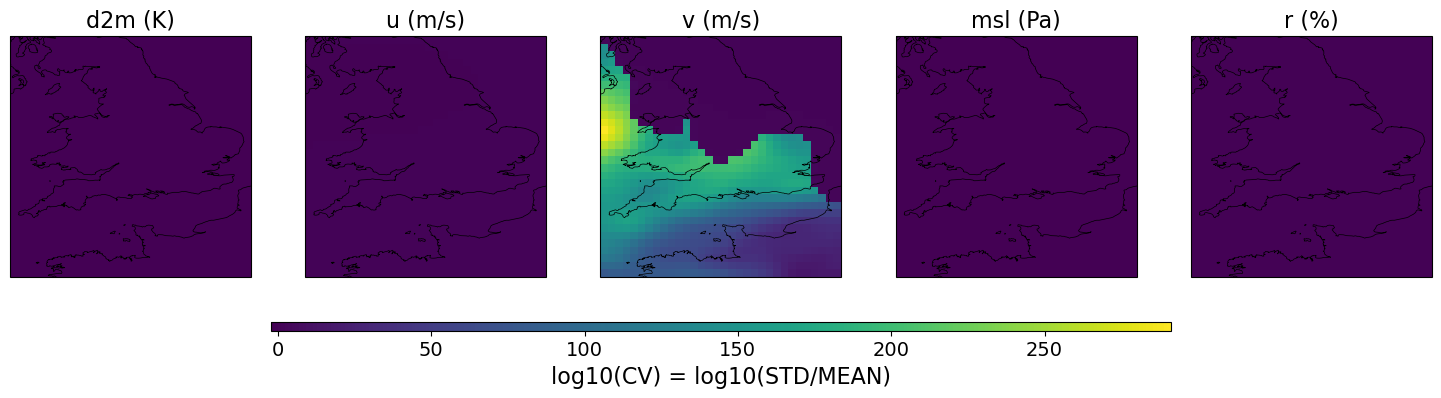

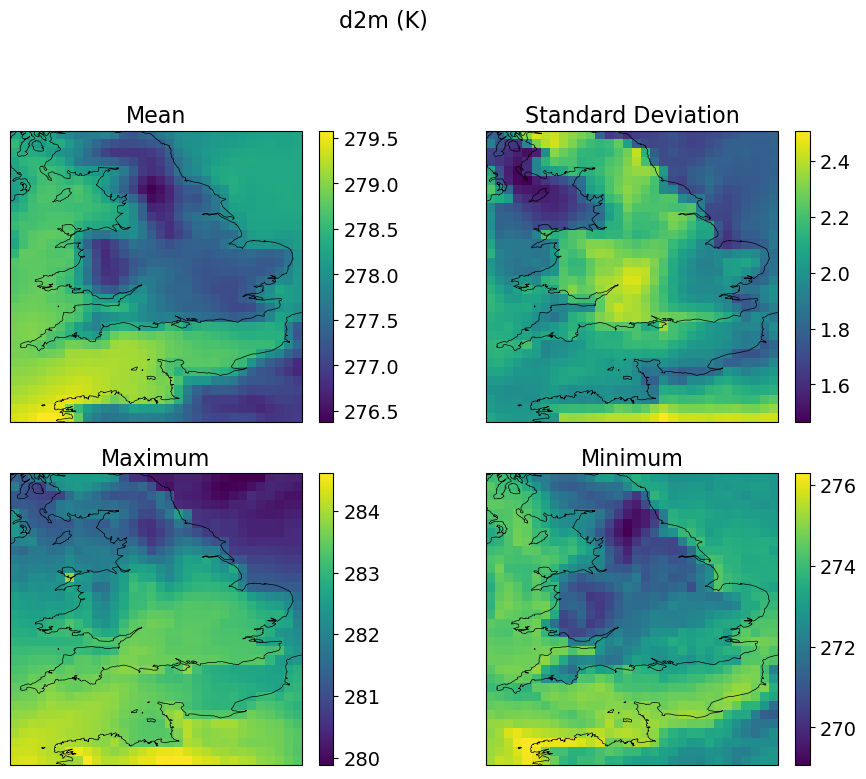

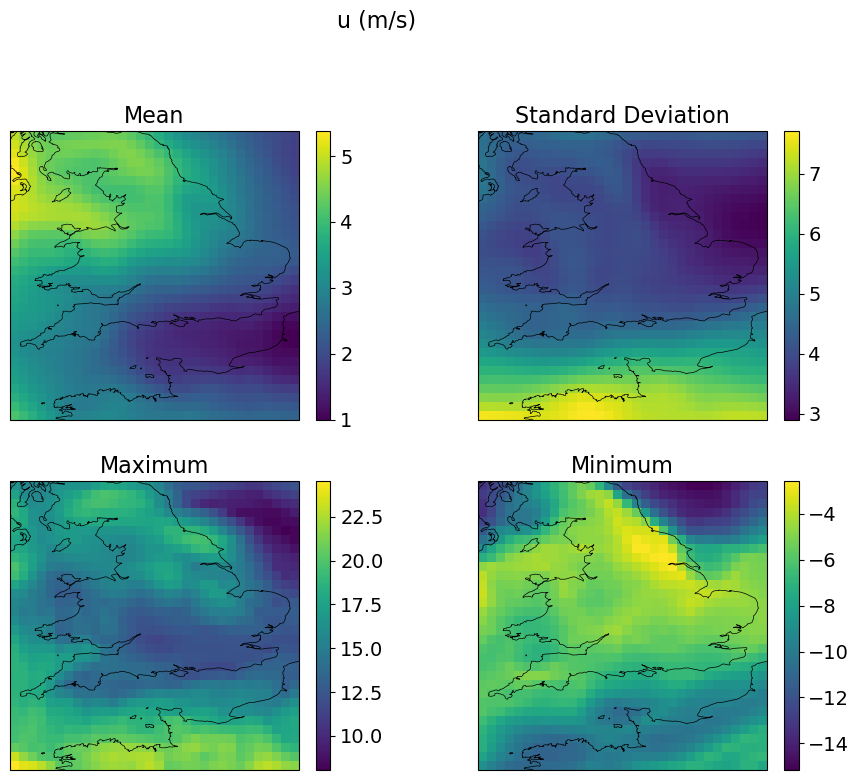

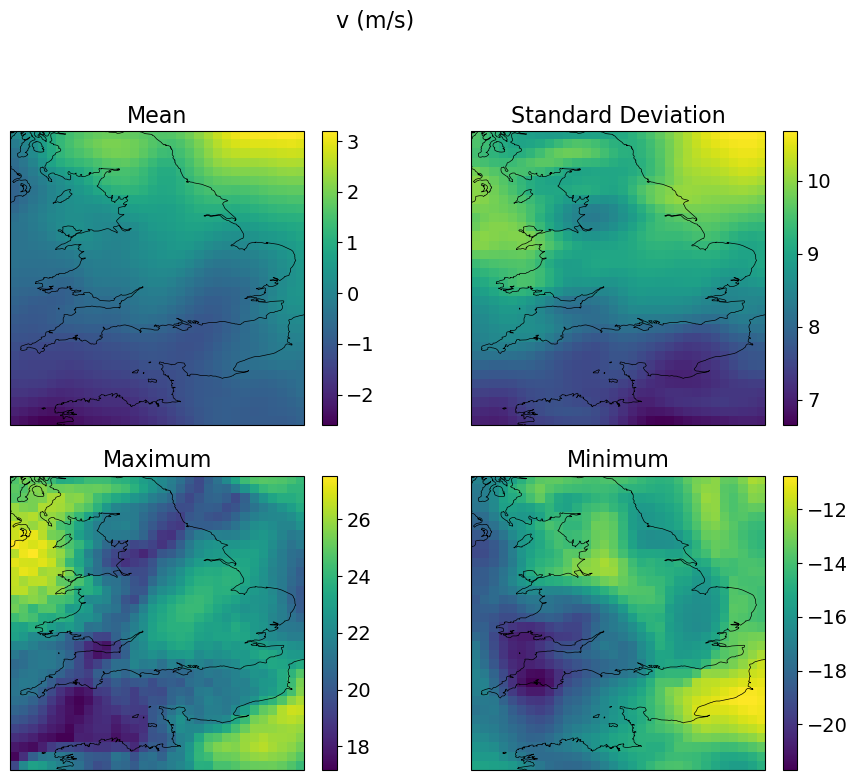

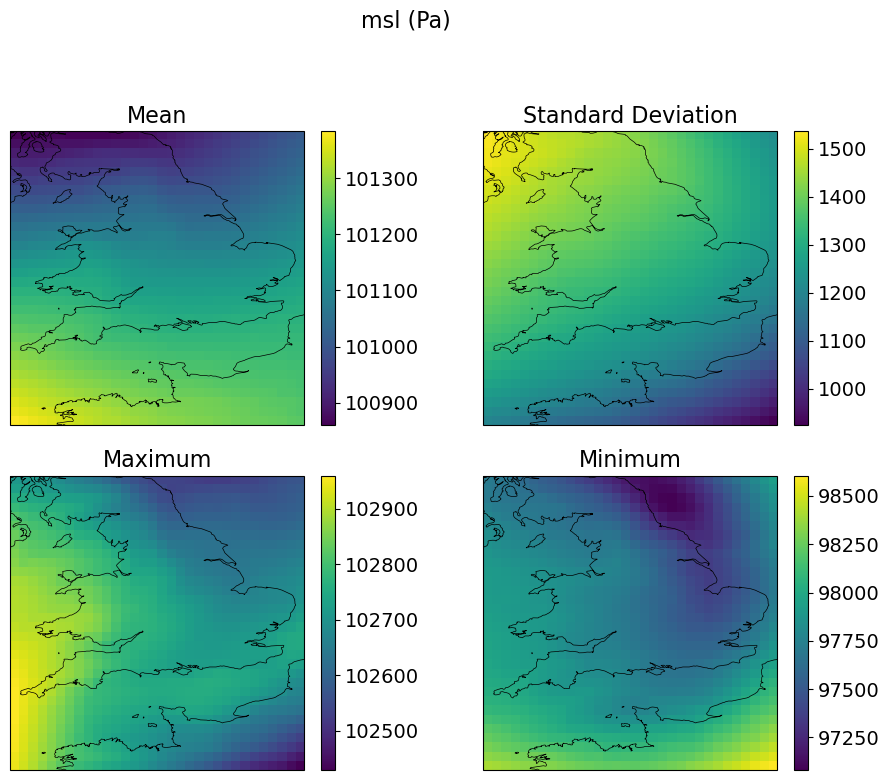

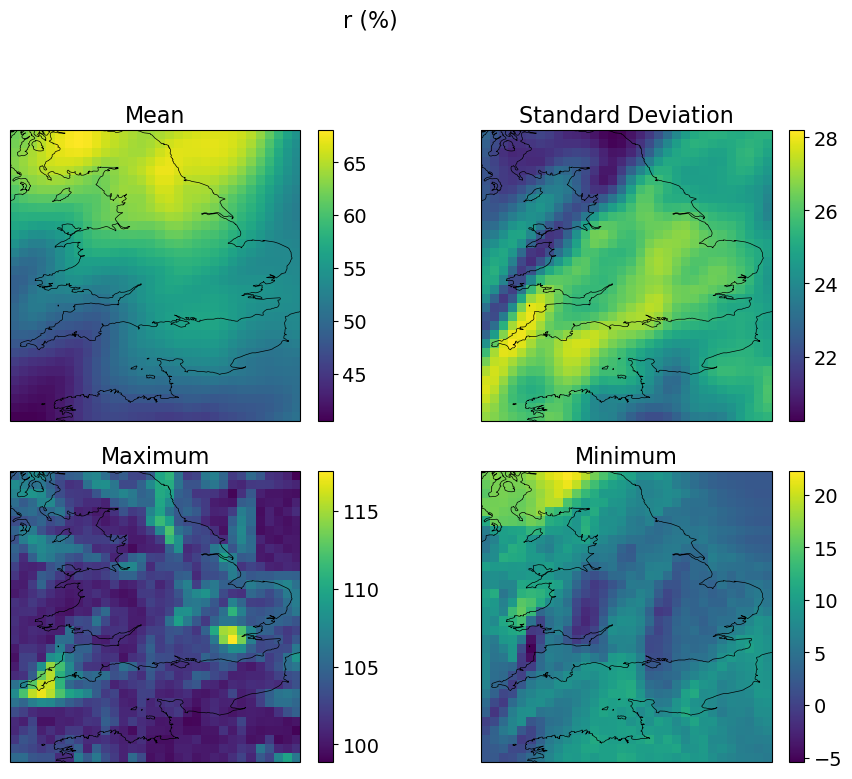

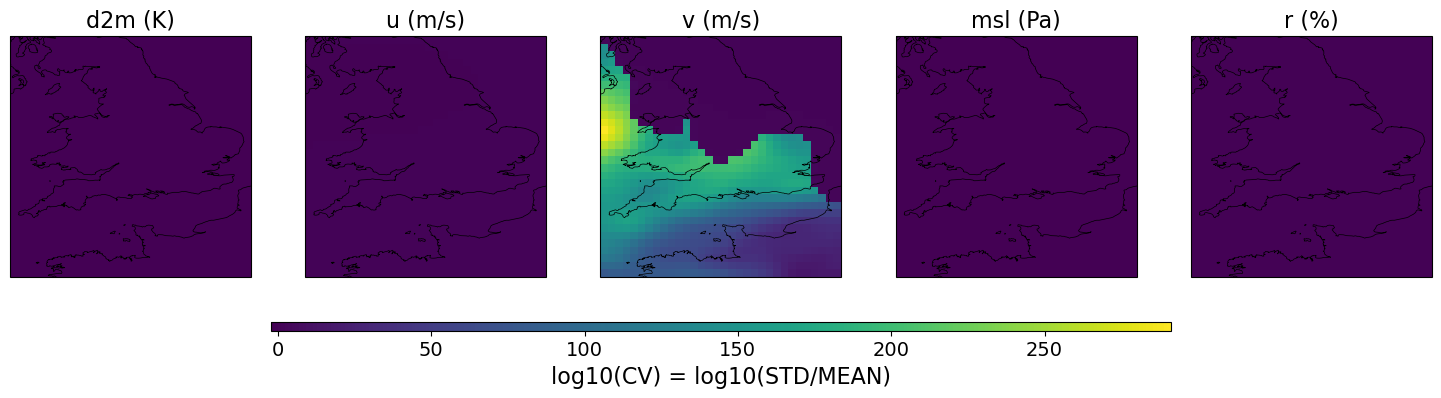

In [7]:
def plot_statistics_with_cartopy(var_data, var_name, var_unit, time_range=366):
    """
    Plot statistical maps with Cartopy for geographical context.
    
    Args:
        var_data (numpy.ndarray): Variable data of shape (time, height, width)
        var_name (str): Name of the variable
        var_unit (str): Unit of the variable
        time_range (int): Number of time points to use
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    return plot_statistics_grid(
        var_data[:time_range], 
        var_name=var_name, 
        var_unit=var_unit,
        with_cartopy=True
    )

# Loop through each variable and create cartographic plots
for var_idx, var_name in enumerate(variable_list):
    var_data = data[:, var_idx, :, :]
    plot_statistics_with_cartopy(var_data, var_name, variable_units[var_idx])

# Plot CV comparison with cartographic features
plot_cv_comparison(data, variable_list, variable_units, with_cartopy=True)

In [8]:
# Convert Moran's I results to a DataFrame for easier analysis
import pandas as pd

if PYSAL_AVAILABLE and 'moran_results' in locals():
    moran_df = pd.DataFrame({
        'Variable': variable_list * 4,
        'Statistic': ['Mean'] * 5 + ['STD'] * 5 + ['Max'] * 5 + ['Min'] * 5,
        'Moran_I': (
            moran_results['mean'] + 
            moran_results['std'] + 
            moran_results['max'] + 
            moran_results['min']
        )
    })

    # Print summary statistics
    print("Summary of Moran's I Spatial Autocorrelation")
    print("============================================")
    print(f"Highest spatial autocorrelation: {moran_df.iloc[moran_df['Moran_I'].argmax()].to_dict()}")
    print(f"Lowest spatial autocorrelation: {moran_df.iloc[moran_df['Moran_I'].argmin()].to_dict()}")
    
    # Group by Variable and get mean Moran's I
    var_summary = moran_df.groupby('Variable')['Moran_I'].mean().sort_values(ascending=False)
    print("\nAverage Moran's I by variable:")
    print(var_summary)
    
    # Group by Statistic and get mean Moran's I
    stat_summary = moran_df.groupby('Statistic')['Moran_I'].mean().sort_values(ascending=False)
    print("\nAverage Moran's I by statistic:")
    print(stat_summary)

# Create summary statistics for coefficient of variation
cv_summary = {}
for var_idx, var_name in enumerate(variable_list):
    var_data = data[:366, var_idx, :, :]
    cv = compute_coefficient_of_variation(var_data, log_transform=False)
    cv_summary[var_name] = {
        'mean_cv': np.mean(cv),
        'median_cv': np.median(cv),
        'min_cv': np.min(cv),
        'max_cv': np.max(cv),
        'spatial_var_cv': np.var(cv)
    }

cv_df = pd.DataFrame(cv_summary).T
print("\nCoefficient of Variation Summary:")
print("=================================")
print(cv_df.sort_values('mean_cv', ascending=False))

Summary of Moran's I Spatial Autocorrelation
Highest spatial autocorrelation: {'Variable': 'msl', 'Statistic': 'Mean', 'Moran_I': 0.9956568252557058}
Lowest spatial autocorrelation: {'Variable': 'r', 'Statistic': 'Max', 'Moran_I': 0.7592324080640709}

Average Moran's I by variable:
Variable
msl    0.991955
u      0.980382
v      0.980228
d2m    0.935348
r      0.906834
Name: Moran_I, dtype: float64

Average Moran's I by statistic:
Statistic
Mean    0.985440
STD     0.964794
Min     0.954513
Max     0.931051
Name: Moran_I, dtype: float64

Coefficient of Variation Summary:
       mean_cv  median_cv       min_cv       max_cv  spatial_var_cv
v    16.325001  -4.969774 -2530.154785  9996.646484    1.329724e+05
u     1.857619   1.457794     0.828596     5.321836    1.026120e+00
r     0.456123   0.461948     0.315933     0.662435    5.414205e-03
msl   0.012846   0.012922     0.009126     0.015230    1.408694e-06
d2m   0.007255   0.007266     0.005255     0.009048    6.070969e-07


## Summary and Conclusions

This notebook has conducted a comprehensive spatial analysis of various weather variables across the UK region, focusing on the statistical properties, spatial variability, and spatial autocorrelation patterns.

### Key Findings:

1. **Statistical Properties**: We analyzed the mean, standard deviation, maximum, and minimum values for each variable, revealing their spatial distributions. These distributions show clear geographical patterns influenced by topography and distance from the coast.

2. **Coefficient of Variation (CV)**: The log-transformed CV (log10(STD/MEAN)) highlighted areas with high relative variability. This metric is particularly useful for comparing variability across different variables with different units and magnitudes.

3. **Spatial Autocorrelation**: Using Moran's I, we quantified the spatial autocorrelation in the data. Higher values indicate stronger spatial patterns (clustering), while lower values suggest more random spatial distributions.

4. **Variable Comparison**: The boxplot analysis revealed differences in the statistical distributions across variables, helping to identify which variables show the most spatial heterogeneity.

### Implications:

- Understanding the spatial patterns of variability is crucial for weather modeling and prediction.
- Areas with high CV might require more careful consideration in weather forecasting or climate analysis.
- The strong spatial autocorrelation in some variables suggests that spatial dependencies should be explicitly accounted for in any modeling approach.
- Variables with different spatial patterns may require different approaches for effective prediction or analysis.

### Next Steps:

- Further analysis could explore the temporal evolution of these spatial patterns.
- Investigating the relationship between these spatial patterns and specific weather events or climate phenomena.
- Incorporating these insights into predictive models to improve their spatial accuracy.

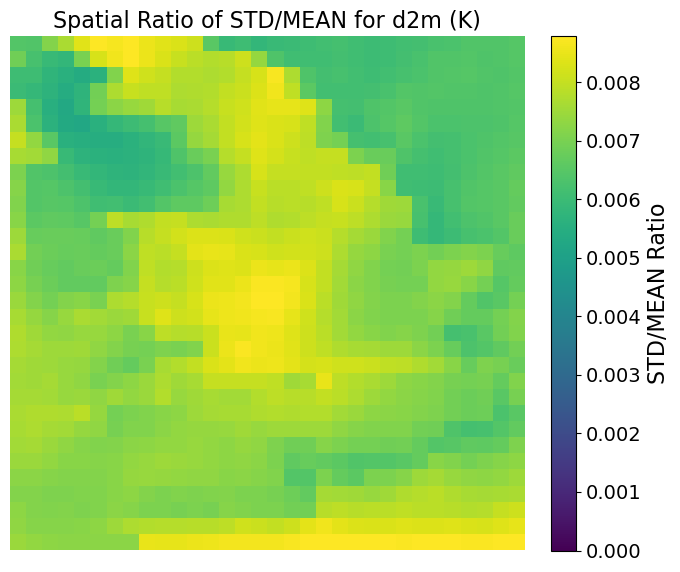

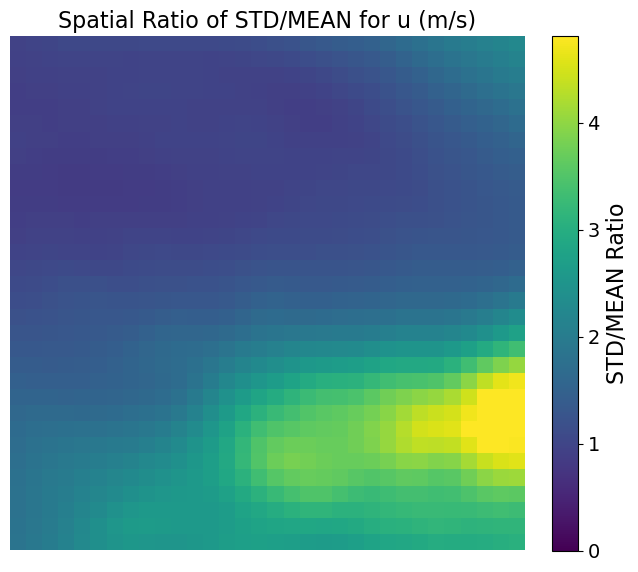

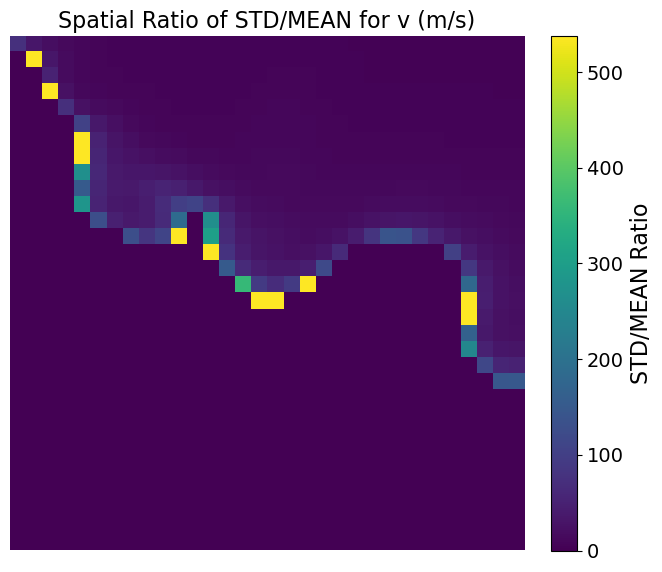

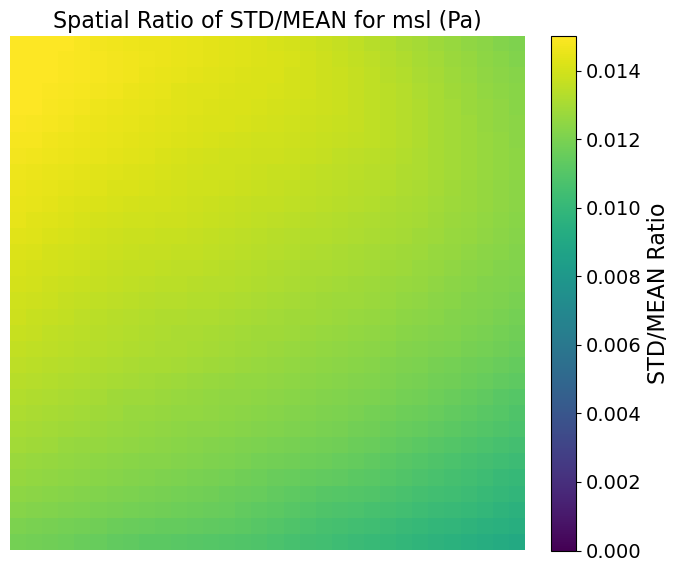

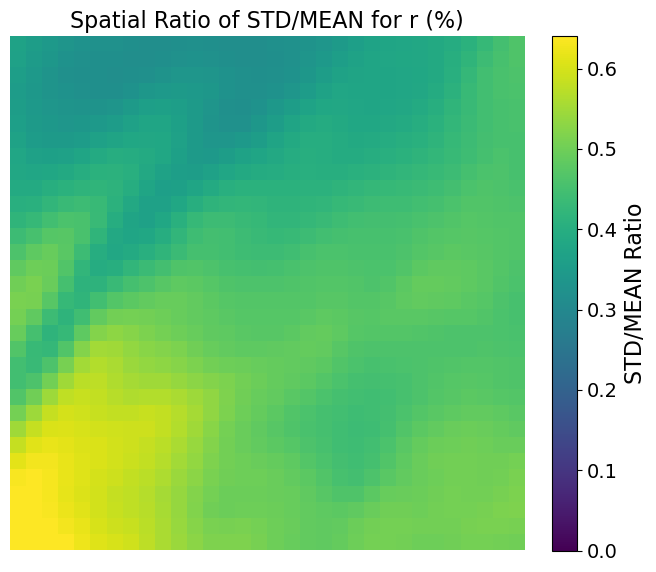

In [9]:
def plot_ratio_maps(data, variable_list, variable_units, time_range=366):
    """
    Plot STD/MEAN ratio maps for each variable.
    
    Args:
        data (numpy.ndarray): Full data array of shape (time, variables, height, width)
        variable_list (list): List of variable names
        variable_units (list): List of variable units
        time_range (int): Number of timestamps to use
    """
    for var_idx, var_name in enumerate(variable_list):
        # Extract variable data
        variable_data = data[:time_range, var_idx, :, :]
        
        # Calculate mean and std
        mean_map = np.mean(variable_data, axis=0)
        std_map = np.std(variable_data, axis=0)
        
        # Calculate ratio, avoiding division by zero
        ratio_map = np.divide(std_map, mean_map, out=np.zeros_like(std_map), where=mean_map != 0)
        
        # Create figure
        plt.figure(figsize=(8, 6))
        im = plt.imshow(ratio_map, cmap="viridis", vmin=0, vmax=np.nanpercentile(ratio_map, 99))
        plt.colorbar(im, fraction=0.046, pad=0.04, label=f"STD/MEAN Ratio")
        plt.title(f"Spatial Ratio of STD/MEAN for {var_name} ({variable_units[var_idx]})")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

# Demonstration: Visualize STD/MEAN ratio for all variables
plot_ratio_maps(data, variable_list, variable_units)


=== Analyzing d2m (K) ===
CV statistics for d2m:
  Mean CV: 0.0073
  Max CV: 0.0090
  Spatial variance of CV: 0.0000

=== Analyzing u (m/s) ===
CV statistics for u:
  Mean CV: 1.8576
  Max CV: 5.3218
  Spatial variance of CV: 1.0261

=== Analyzing v (m/s) ===
CV statistics for v:
  Mean CV: 16.3250
  Max CV: 9996.6465
  Spatial variance of CV: 132972.4062

=== Analyzing msl (Pa) ===
CV statistics for msl:
  Mean CV: 0.0128
  Max CV: 0.0152
  Spatial variance of CV: 0.0000

=== Analyzing r (%) ===
CV statistics for r:
  Mean CV: 0.4561
  Max CV: 0.6624
  Spatial variance of CV: 0.0054
Processing variable: d2m
Processing variable: u
Processing variable: v
Processing variable: msl
Processing variable: r


/tmp/ipykernel_254438/363297914.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Spatial Autocorrelation Summary:

MEAN - Moran's I values:
  d2m: 0.9531
  u: 0.9921
  v: 0.9933
  msl: 0.9957
  r: 0.9930

STD - Moran's I values:
  d2m: 0.8894
  u: 0.9920
  v: 0.9904
  msl: 0.9943
  r: 0.9579

MAX - Moran's I values:
  d2m: 0.9752
  u: 0.9707
  v: 0.9606
  msl: 0.9895
  r: 0.7592

MIN - Moran's I values:
  d2m: 0.9237
  u: 0.9667
  v: 0.9766
  msl: 0.9884
  r: 0.9173


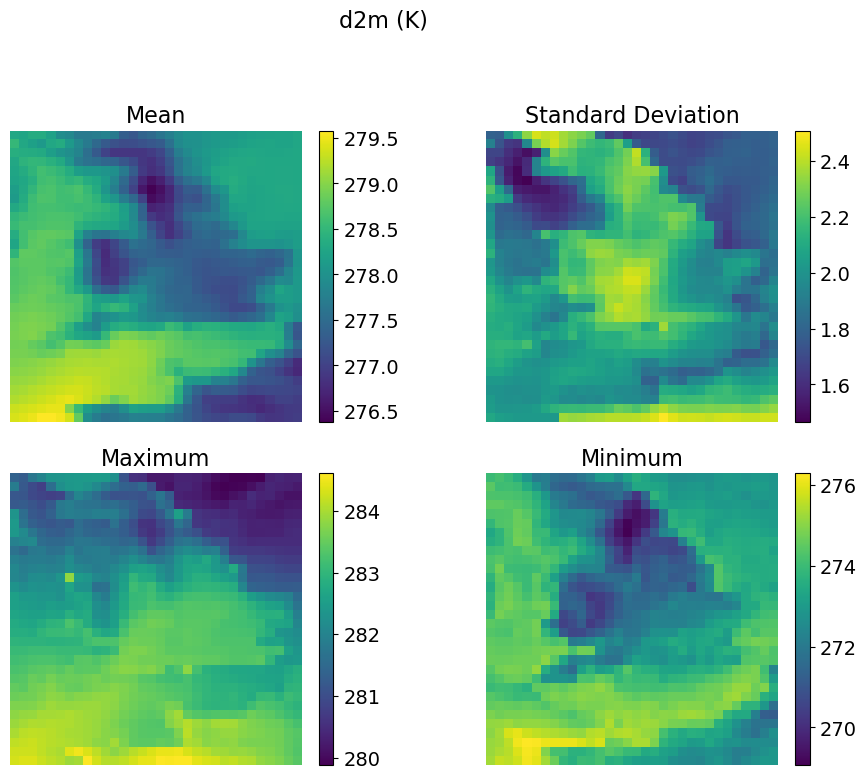

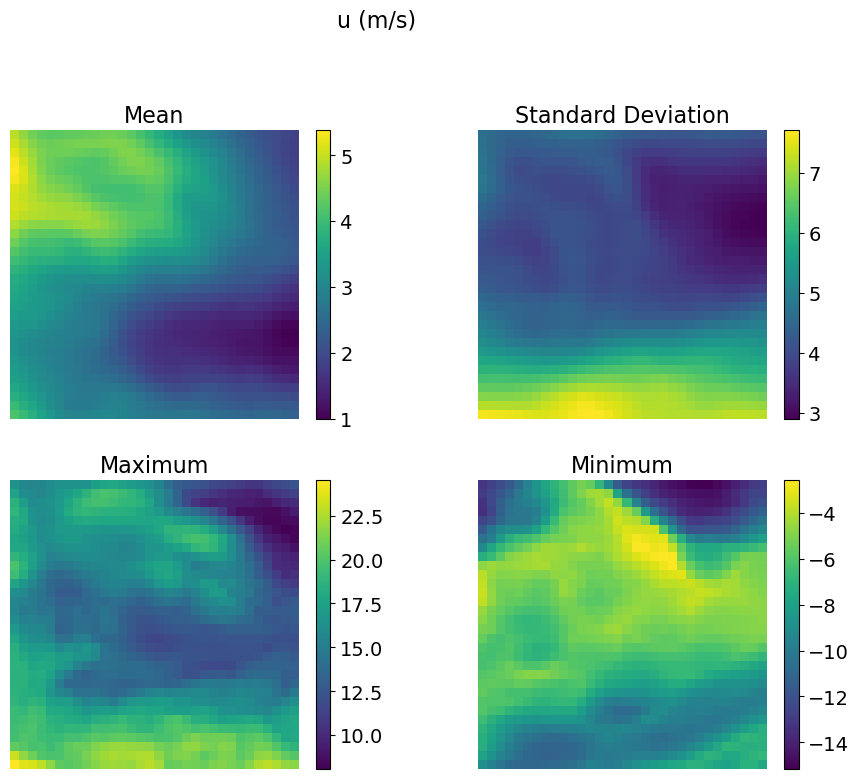

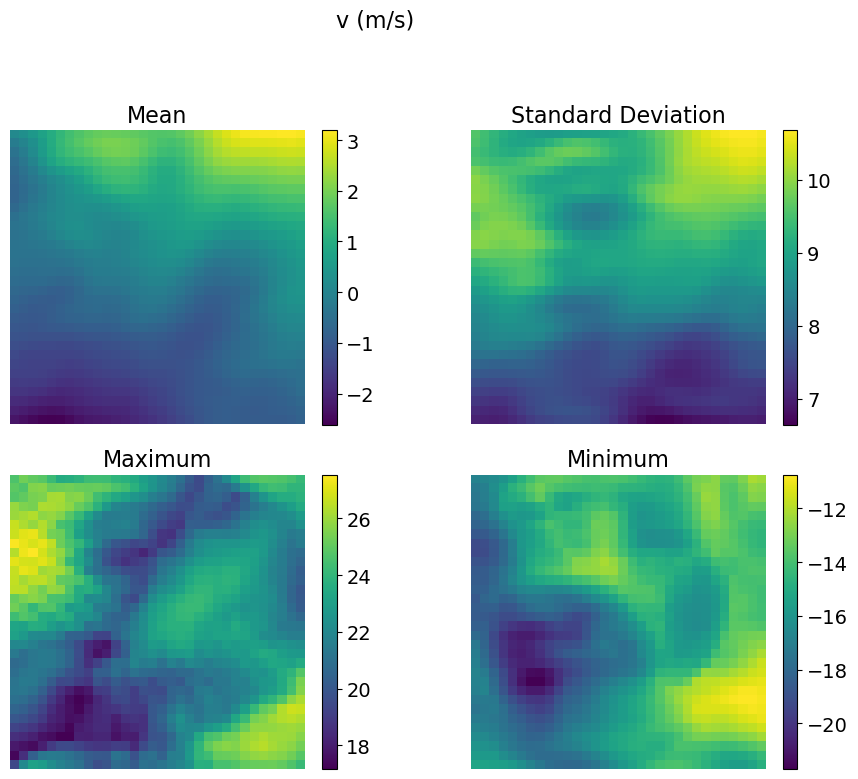

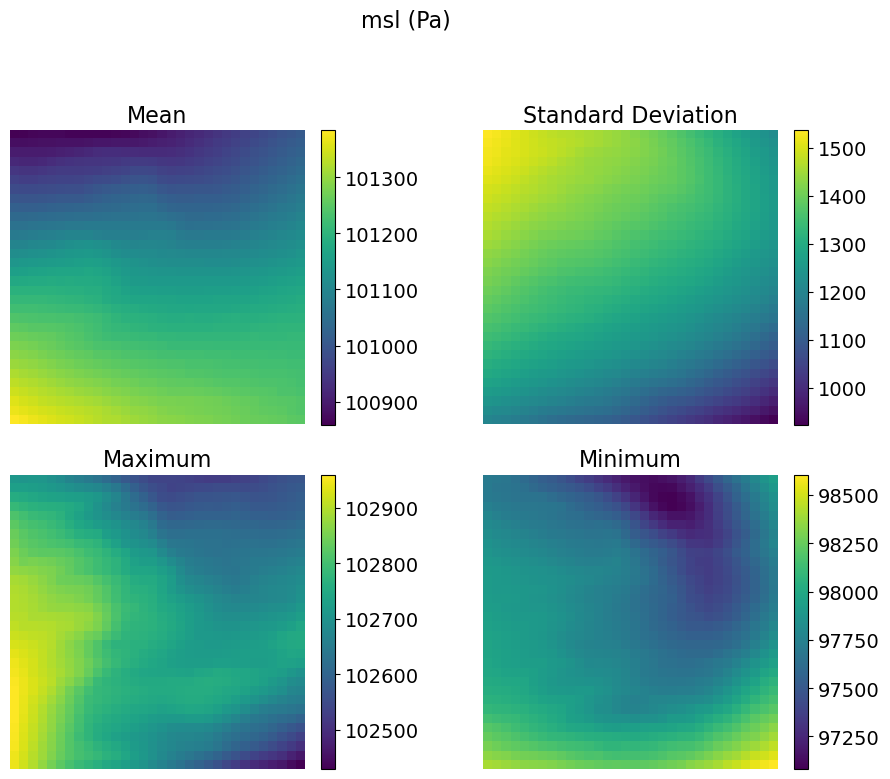

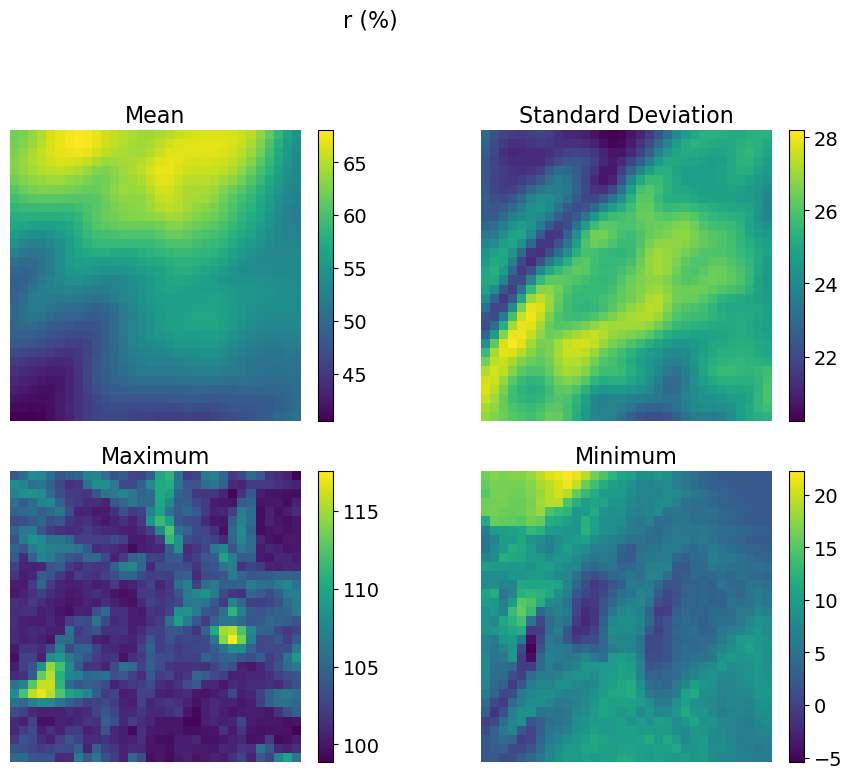

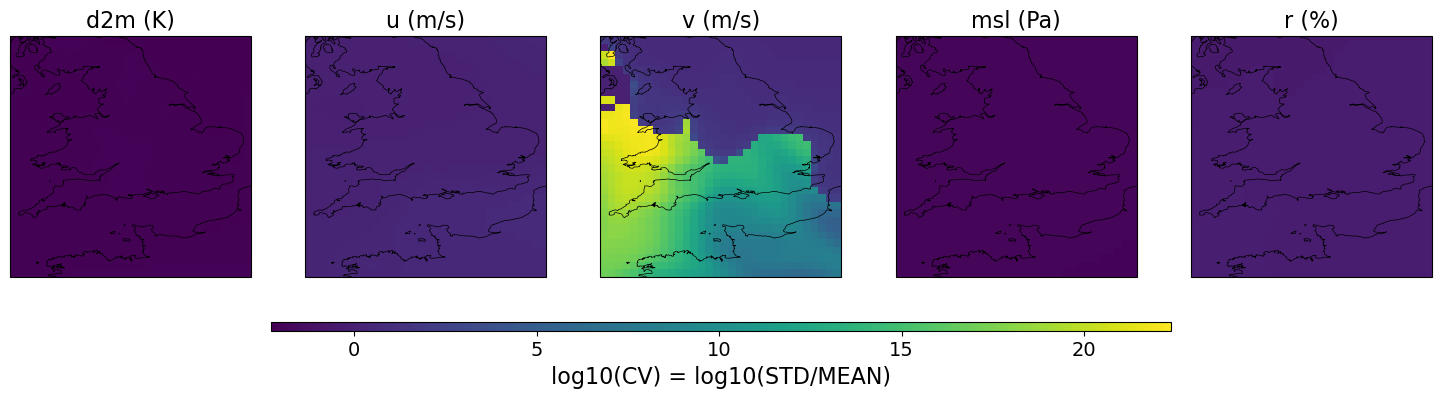

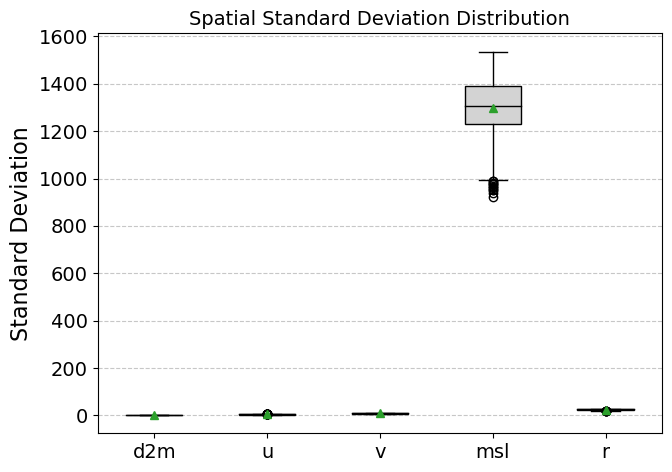

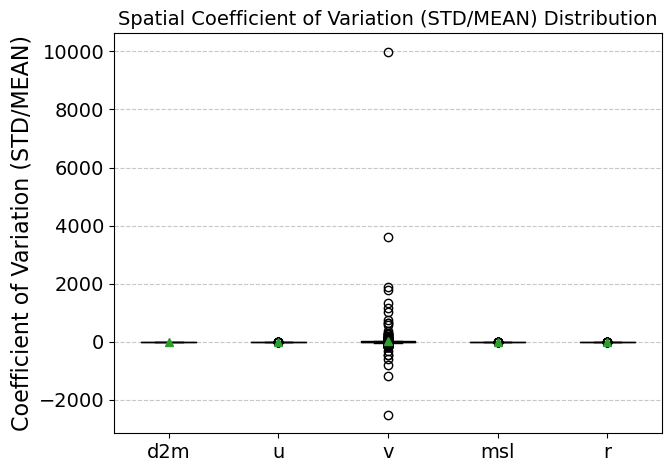

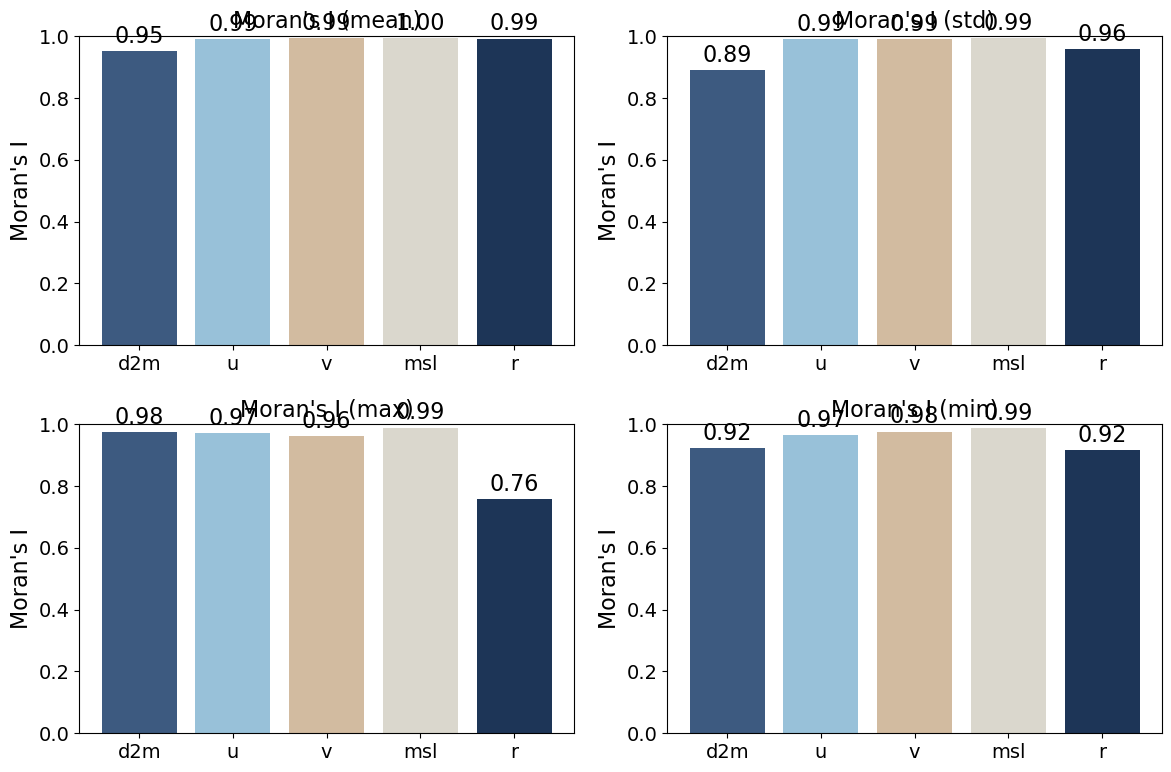

: 

In [ ]:
# This cell demonstrates how to run a complete analysis using the refactored functions

# Set environment and load data
set_plot_style(16)  # Set a consistent style for all plots

# Create a consistent data reference
data = atmosphere_data  # Use the original variable name

# Analyze each variable individually
for var_idx, var_name in enumerate(variable_list):
    print(f"\n=== Analyzing {var_name} ({variable_units[var_idx]}) ===")
    
    # Extract variable data
    var_data = data[:, var_idx, :, :]
    
    # 1. Statistical analysis
    plot_statistics_grid(
        var_data, 
        var_name=var_name, 
        var_unit=variable_units[var_idx],
        time_range=366
    )
    
    # 2. CV analysis
    cv_map = compute_coefficient_of_variation(
        var_data[:366], 
        log_transform=False
    )
    
    print(f"CV statistics for {var_name}:")
    print(f"  Mean CV: {np.nanmean(cv_map):.4f}")
    print(f"  Max CV: {np.nanmax(cv_map):.4f}")
    print(f"  Spatial variance of CV: {np.nanvar(cv_map):.4f}")

# Generate comparative visualizations
# 1. CV comparison across variables
plot_cv_comparison(data, variable_list, variable_units, time_range=366)

# 2. Boxplot comparison of spatial variability
plot_variable_boxplot(data, variable_list, variable_units, stat_type="std")
plot_variable_boxplot(data, variable_list, variable_units, stat_type="cv")

# 3. Moran's I analysis (if available)
if PYSAL_AVAILABLE:
    # Calculate spatial statistics
    spatial_stats = calculate_spatial_statistics(data, variable_list)
    
    # Calculate and plot Moran's I
    moran_results = calculate_morans_i(spatial_stats, variable_list)
    plot_morans_i(moran_results, variable_list)
    
    # Create summary statistics
    print("\nSpatial Autocorrelation Summary:")
    for stat in ["mean", "std", "max", "min"]:
        print(f"\n{stat.upper()} - Moran's I values:")
        for i, var in enumerate(variable_list):
            print(f"  {var}: {moran_results[stat][i]:.4f}")